## ***Intro***

The dataset of the "*Home Credit - Credit Risk Model Stability*" competition is definitely the largest dataset I have ever worked with in my young data science journey. There are just so many tables, rows and columns that we just can't reason with it the way we do with a single (base) table dataset. Extracting meaningful features for classification from all these tables seems even more challenging that the actual stability challenge of the competition (particularly when you are not an experienced Data engineer).\
The competition is about to end in roughly one week, there is no more time for manual feature engineering (supposing any team even tried it).\
In this Notebook I propose to explore the machine approach to creating features from raw data, **Automatic Feature Engineering**. AFE is the process of automatically creating hundreds or thousands of new features from a set of related tables in a fraction of the time as the manual approach. In this notebook, we will apply automated feature engineering to the Home Credit - Credit Risk Model Stability dataset using ***[Featuretools](http://www.featuretools.com/)*** an open source python framework for automated feature engineering and ***[Dask](http://www.dask.org)*** for parallel computing.

## ***Install Dask.distributed***

All the imported libraries should already be installed if your running this on kaggle except dask.distributed (that is intalled by the command below)

In [3]:
# You can comment this line if dask[distributed] is already installed in your environment
%pip install dask[distributed]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## ***Imports***

In [5]:
# For data manipulation
import pandas as pd

# To garbage collect the dataframes when their are not needed anymore
import gc
# For retrieving files which have a certain pattern in their names (eg: train_applprev_1*.parquet)
import glob
# To perform system operations
import os
import sys
# To filter warnings
import warnings

# For Automated Feature engineering 
import featuretools as ft

# For parallel computation
import dask.bag as db
from dask.distributed import Client, progress

## ***Functions***

In [6]:
def partition_dataset(root_dir, entity_names, length_partitions):
    """
    Partitions the dataset based on case_id values in the base table and entity names.
    
    Args:
        root_dir (str): Path to the directory containing the original tables (Competition dataset)
        entity_names (list): List of entity names (e.g., ["static_0", "applprev_1", "base", ...]).
        length_partitions (int): Number of case_ids per partition.
    
    Returns:
        None: The function creates subsets of each entity (per case_id) in each partition.
    """
    # Read base table
    base_df = pd.read_parquet(root_dir + "base.parquet")
    case_id_subsets = [base_df["case_id"].iloc[i:i+length_partitions] for i in range(0, base_df.shape[0], length_partitions)]
    # Delete the table and keep only the subset ids since base will also be partitionned
    del base_df
    gc.collect()
    
    # Iterate through partitions and entities
    for partition_id, case_id_subset in enumerate(case_id_subsets):
        # Make the directory for partition
        directory = f"/kaggle/working/partitions/partition{partition_id + 1}"
        if os.path.exists(directory):
            continue
        
        os.makedirs(directory)
        for entity_name in entity_names:
            # Check for single or multiple table entity
            entity_files = glob.glob(f"{root_dir}{entity_name}*.parquet")
            
            if len(entity_files) == 1:
                # Single table entity
                entity_df = pd.read_parquet(entity_files[0])
                subset_df = entity_df[entity_df["case_id"].isin(case_id_subset)]
                subset_df.to_parquet(f"{directory}/{entity_name}.parquet")
                del entity_df, subset_df
                gc.collect()
            else:
                # Multiple table entity
                entity_df = pd.read_parquet(entity_files[0])
                subset_df = entity_df[entity_df["case_id"].isin(case_id_subset)]
                for file_path in entity_files[1:]:
                    entity_df = pd.read_parquet(file_path)
                    subset_continue = entity_df[entity_df["case_id"].isin(case_id_subset)]
                    if not subset_continue.empty:
                        subset_df = pd.concat([subset_df, subset_continue])
                # Save subset and delete intermetiade tables.
                # Note that this line will save the subset_df even if it's empty (meaning there is no info 
                # regarding the specific subset of case_ids in that particular entity, same for single table entities)
                # Each EntitySet should have the same number of entities in order to calculate the same features for each partition 
                subset_df.to_parquet(f"{directory}/{entity_name}.parquet")
                del entity_df, subset_df, subset_continue
                gc.collect()
        print(f"Done parition{partition_id}, saved in {directory}")

def read_and_init_ww(path, name, logical_types=None):
    """
    Reads a DataFrame from a Parquet file, initializes it with Woodwork, and performs basic data typing and semantic tagging.
    
    Args:
        path (str): Path to the Parquet file containing the DataFrame.
        name (str): Name to assign to the DataFrame within Woodwork.
        logical_types (dict): A dictionary with the logical types of the different columns in the EntitySet that was used when building the features (Default to None)
        
    Returns:
        pandas.DataFrame: The loaded and Woodwork-initialized DataFrame.
    
    Raises:
        ValueError: If the provided path does not point to a valid Parquet file.
  """
    try:
        df = pd.read_parquet(path)
    except FileNotFoundError:
        raise ValueError(f"Invalid path: {path}")
    
    if name == "base":
        #Drop MONTH because it can be calculated with "date_decision"
        # And target because because we don't want any features to be derived from the target to predict
        df.drop(columns=["MONTH", "target"], inplace=True)
        # Init woodwork DataFrame
        df.ww.init(name=name, index="case_id")
        print("Initialized dataframe $base, target and MONTH dropped")
        return df
    
    # Set a unique index
    df.reset_index(drop=True, inplace=True)
    df["id"] = df.index
    if logical_types:
        logical_types = logical_types[name]
        # This block of code has been added in response to a ValueError that occurred when runing the Bag for the first time
        for col, l_type in logical_types.items():
            if str(l_type) == "Boolean":
                logical_types[col] = "BooleanNullable"
                print(f"Changed logical type of column {col} from Boolean to BooleanNullable")
        df.ww.init(name=name, index="id", logical_types=logical_types)
    else:
        df.ww.init(name=name, index="id")
        
    # Convert integer representations of booleans to true Booleans and Add semantic tags to birth dates
    for col in df.columns:
        # Woodwork should properly infer the correct logical types for all the columns but this is a precaution
        if not logical_types: # Running for the reference partition
            if set(df[col].unique()) == {0,1} and str(df.ww.logical_types[col]) == "Integer":
                df.ww.set_types(logical_types={col: "Boolean"})
                print("Type Integer changed to true logical type Bool")
            if col[-1] == "P" and str(df.ww.logical_types[col]) != "Double":
                df.ww.set_types(logical_types={col: "Double"})
            if col[-1] == "M" and str(df.ww.logical_types[col]) != "Categorical":
                df.ww.set_types(logical_types={col: "Categorical"})
            if col[-1] == "A" and str(df.ww.logical_types[col]) != "Double":
                df.ww.set_types(logical_types={col: "Double"})
            if col[-1] == "D" and str(df.ww.logical_types[col])!= "Datetime":
                df.ww.set_types(logical_types={col: "Datetime"})  
        # Add semantic_tags to birth dates columns    
        if col.__contains__("birth"):
            df.ww.add_semantic_tags(semantic_tags = {col: "date_of_birth"})
            print(f"Added semantic tag $date_of_birth to col {col}")
    print(f"Initialized dataframe ${name}, no columns dropped")
    return df

def add_relationships(es, children_names, parent_name="base"):
    """
    Adds a relationship between a parent Entity and its childrens within a Featuretools EntitySet.
    
    Args:
        es (featuretools.EntitySet): The Featuretools EntitySet to add the relationship to.
        child_names (list[str]): The names of the child DataFrames/Entities within the EntitySet.
        parent_name (str, optional): The name of the parent DataFrame/Entity (defaults to "base").
    
    Returns:
        featuretools.EntitySet: The modified EntitySet with the added relationship.
    """
    for child_name in children_names:
        es = es.add_relationship(
        parent_dataframe_name=parent_name,
        parent_column_name="case_id",
        child_dataframe_name=child_name,
        child_column_name="case_id")
    return es

def entitySet_from_part(path_part, dfs_logical_types=None):
    """
    This function constructs a Featuretools EntitySet from a partition path.
    
    Args:
        path_part (str): The path of the partition (should contains all 17 entities). 
        dfs_logical_types: The logical types in the EntitySet that has been used to build the feature (Default to None)
    Returns:
        dict: A dictionary containing two keys:
        - "es" (Featuretools.EntitySet): The constructed Featuretools EntitySet containing all entities and their relationships.
        - "num_partition" (str): The extracted partition number from the provided path.
    """
    # Filter warnings
    warnings.filterwarnings('ignore')
    
    entities_paths = glob.glob(path_part + "/*")
    entities_names = [path.split("/")[-1].split(".")[0] for path in entities_paths]
    children_names = entities_names.copy()
    children_names.remove("base")
    dfs = [read_and_init_ww(path=path, name=name, logical_types=dfs_logical_types) for path, name in zip(entities_paths, entities_names)]
    es = ft.EntitySet(id="home_credit")
    for df in dfs:
        es.add_dataframe(dataframe=df)
    es = add_relationships(es=es, children_names=children_names)
    return {"es": es, "num_partition": path_part[20:]}

def get_unknownType_columns(entityset):
    """
    Finds columns with the logical type "Unknown" in a Featuretools EntitySet.
    
    Args:
        entityset (Featuretools.EntitySet): The EntitySet to analyze.
    
    Returns:
        list: A list of tuples containing (entity_name, column_name) for unknown types.
    """
    unknown_columns = []
    for entity in entityset.dataframes:
        for column in entity.columns:
            if str(entity.ww.logical_types[column]) == "Unknown":
                unknown_columns.append((entity.ww.name, column))
    return unknown_columns

def feature_matrix_from_es(es_dict, feature_defs, return_fm = False):
    """
    Calculates and saves a feature matrix from an EntitySet.
    
    Args:
        es_dict (dict): Output dictionary from entitySet_from_part.
        feature_defs (list): List of Featuretools feature definitions.
        return_fm (bool, optional): If True, return the feature matrix (default: False, saves to Parquet file).
    
    Returns:
        None (default) or pandas.DataFrame:
    """
    # Filter warnings
    warnings.filterwarnings('ignore')
    
    # Extract the entityset from the dictionary returned by entitySet_from_part
    es = es_dict['es']
    # Calculate the feature matrix and save
    feature_matrix = ft.calculate_feature_matrix(feature_defs, entityset=es, n_jobs=1, chunk_size = es['base'].shape[0], verbose=True)
    print("Done feature matrix " + es_dict["num_partition"])
    # Save fm to parquet
    feature_matrix.to_parquet('/kaggle/working/feature_matrices/partition' + es_dict["num_partition"] + "_fm.parquet")
    print("Saved feature matrix " + es_dict["num_partition"])
    
    if return_fm:
        return feature_matrix


## ***Partitioning the dataset***

**First and foremost we need to repartition the competion dataset**\
We will divide the dataset by training examples and entities, currently the dataset for this competion contains 17 "entities", some of which spread in multiple tables like **credit_bureau_a_1**. We want independent partitions containing all the informations about a subset of ***n*** training examples or ***case_ids***\
Creating partitions that contain all the entities necessary to create an EntitySet (one entity == one table) for a subset of the training examples will allow us to calculate features matrices for the different subsets independently and simultaneously on different cpu cores with dask bags

In [ ]:
!mkdir partitions
%ls

In [ ]:
train_root = "/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/train_"
entity_names = ["base", "static_0", "static_cb_0", "applprev_1", "other_1", "tax_registry_a_1","tax_registry_b_1", 
            "tax_registry_c_1", "credit_bureau_a_1", "credit_bureau_b_1", "deposit_1", "person_1", "debitcard_1", 
            "applprev_2", "person_2", "credit_bureau_a_2", "credit_bureau_b_2"]

In [ ]:
# Partition the dataset, 12,000 case_ids per partition (This operation will take a while)
partition_dataset(root_dir=train_root, entity_names=entity_names, length_partitions=12000)

## ***Deep Features Synthesis***

The automatic creation of features is a relatively recent concept in the field of data science but with undeniable potential to reduce the workload of data scientists, particularly at the data level. The concept was first formalized by James Max Kanter and Kalyan Veeramachaneni in their 2015 paper ("Deep feature synthesis: Towards automating data science endeavors"), where they proposed an algorithm to automatically generate predictors for relational datasets. This is the Deep Feature Synthesis algorithm (Kanter and Veeramachaneni, 2015).

The algorithm follows the relationships between different tables and a base table, then sequentially applies mathematical functions along these paths to create features. The algorithm takes as input an interconnected set of entities/tables.

In the paper, the authors described two types of relations between entities: forward and backward, and three types of features for an entity based on the types of relations it maintains with other entities: entity features (efeat), direct features (dfeat), and relational features (rfeat).

In a forward relation, an instance of an entity E<sup>L</sup> is associated with a single instance of another entity E<sup>k</sup>. The backward relation is the relation of an instance i in E<sup>k</sup> to all instances m = {1 . . . M} in E<sup>L</sup> with which it has a forward relation with k.

A trivial example is that of a "parent-child" relation where a child basically has only one parent while the parent can have many children. Scientists have largely adopted this terminology.

- **Entity Features (efeat)**: These are features directly related to the entity (variables in the base table of the entity) such as gender, age, income, etc. Depending on the variable to be predicted, this type of feature could even be used directly as predictors. Transformations can also be applied to them, for example: transforming a timestamp into day, month, year, and hour or calculating age from the date of birth.

- **Direct Features (dfeat)**: Direct features are applied to forward relations (Child -> Parent). In these, features of entity i ∈ E<sup>k</sup> (child) are directly transferred as characteristics for entity m ∈ E<sup>L</sup> (parent). An example could be the price of a product becoming an attribute in the orders table (a feature for the Order entity).

- **Relational Features (rfeat)**: Relational features are applied to backward relations (Parent -> Children). They are derived for an instance i of entity Ek by applying a mathematical function to x<sup>L</sup><sub>:,j|ek =i</sub>, which is a collection of values for a feature j in entity E<sup>L</sup>, assembled by extracting all values of j in entity E<sup>L</sup> where the identifier of E<sup>k</sup> is e<sup>k</sup> = i. This transformation is given by the formula: x<sup>k</sup><sub>i,j’</sub>= rfeat(x<sup>L</sup><sub>:,j|ek =i</sub>). Some examples of rfeat functions are min, max, and count.

The goal of the Deep Feature Synthesis algorithm is to find and compute the dfeats and rfeats for a target entity E<sup>k</sup>, add them to the E<sup>k</sup> table, and calculate the efeats on all of this. 

In the case where a child entity of the target entity has its own children, we can recursively generate features using the same sequence described above. Recursion can end when a certain depth is reached or there are no more children. This [image](https://drive.google.com/file/d/13vDhyJVkxBeBMiG_UxRSpydSIXWDqfLz/view?usp=sharing) illustrates an example application of the algorithm

Featuretools already implements these concepts, the following cells create an EntitySet from one of the partitions created above and run dfs to get 2526 new features derived from the given entityset.

In [4]:
# We will use only one entitySet to run dfs and get the features that we will later calculate for all partitions
# In theory you can use whatever partition you want to build this EntitySet, but in some partitions there are tables that don't have any row
# these tables' columns (T or L unspecified transforms) will be inferred by woodwork with the datatypes "unknown" 
# which will impact the features generated by DFS. To avoid this I recommand choosing a partition where all the 
# tables have at least one row (here I found partition5) after some trials
es_dict = entitySet_from_part("partitions/partition5")

Initialized dataframe $credit_bureau_a_2, no columns dropped
Initialized dataframe $deposit_1, no columns dropped
Initialized dataframe $credit_bureau_a_1, no columns dropped
Initialized dataframe $other_1, no columns dropped
Initialized dataframe $debitcard_1, no columns dropped
Initialized dataframe $credit_bureau_b_1, no columns dropped
Initialized dataframe $applprev_1, no columns dropped
Initialized dataframe $static_0, no columns dropped
Added semantic tag $date_of_birth to col birth_259D
Added semantic tag $date_of_birth to col birthdate_87D
Initialized dataframe $person_1, no columns dropped
Initialized dataframe $tax_registry_c_1, no columns dropped
Initialized dataframe $tax_registry_a_1, no columns dropped
Added semantic tag $date_of_birth to col birthdate_574D
Added semantic tag $date_of_birth to col dateofbirth_337D
Added semantic tag $date_of_birth to col dateofbirth_342D
Initialized dataframe $static_cb_0, no columns dropped
Initialized dataframe $tax_registry_b_1, no co

In [5]:
es = es_dict["es"]
es

Entityset: home_credit
  DataFrames:
    credit_bureau_a_2 [Rows: 952885, Columns: 20]
    deposit_1 [Rows: 842, Columns: 6]
    credit_bureau_a_1 [Rows: 101303, Columns: 80]
    other_1 [Rows: 163, Columns: 8]
    debitcard_1 [Rows: 904, Columns: 7]
    credit_bureau_b_1 [Rows: 708, Columns: 46]
    applprev_1 [Rows: 30791, Columns: 42]
    static_0 [Rows: 12000, Columns: 169]
    person_1 [Rows: 33512, Columns: 38]
    tax_registry_c_1 [Rows: 6749, Columns: 6]
    tax_registry_a_1 [Rows: 12556, Columns: 6]
    static_cb_0 [Rows: 11208, Columns: 54]
    tax_registry_b_1 [Rows: 20372, Columns: 6]
    credit_bureau_b_2 [Rows: 10461, Columns: 7]
    applprev_2 [Rows: 55926, Columns: 7]
    person_2 [Rows: 11025, Columns: 12]
    base [Rows: 12000, Columns: 3]
  Relationships:
    credit_bureau_a_2.case_id -> base.case_id
    deposit_1.case_id -> base.case_id
    credit_bureau_a_1.case_id -> base.case_id
    other_1.case_id -> base.case_id
    debitcard_1.case_id -> base.case_id
    credi

In [6]:
es["base"]

,case_id,date_decision,WEEK_NUM
48000,48000,2020-02-27,60
48001,48001,2020-02-28,60
48002,48002,2020-02-28,60
48003,48003,2020-03-03,61
48004,48004,2020-02-27,60
...,...,...,...
105429,105429,2019-01-19,2
105430,105430,2019-01-17,2
105431,105431,2019-01-17,2
105432,105432,2019-01-17,2


In [7]:
# Even if we have an entityset that have no empty dataframes, we still can have some columns with no values
# Given that some columns in the original Dataset have 90+% null values, it's definitely possible and these columns...
# will be infered by woodwork as unknown (though we should have significantly less unknwon columns) so we will have to type them manually
unknowns = get_unknownType_columns(es)
unknowns

[('credit_bureau_b_1', 'periodicityofpmts_997L')]

In [8]:
# Fortunately we have just one unknown type columns so we can easily set his type manually after checking the original dataset
es['credit_bureau_b_1'].ww.set_types(logical_types={'periodicityofpmts_997L': "Categorical"})

In [9]:
# Save the logical types of all the columns in the EntitySet that we will use to build the features
# This will be passed to the entitySet_from_part function so to ensure that the same columns 
# from different partitions will have the same logical types 
logical_types = {}

for df in es.dataframes:
    logical_types[df.ww.name] = df.ww.logical_types

logical_types["base"]

{'case_id': <Integer at 0x79af61afd8d0>,
 'date_decision': <Datetime at 0x79af61afdab0>,
 'WEEK_NUM': <Integer at 0x79af61baa050>}

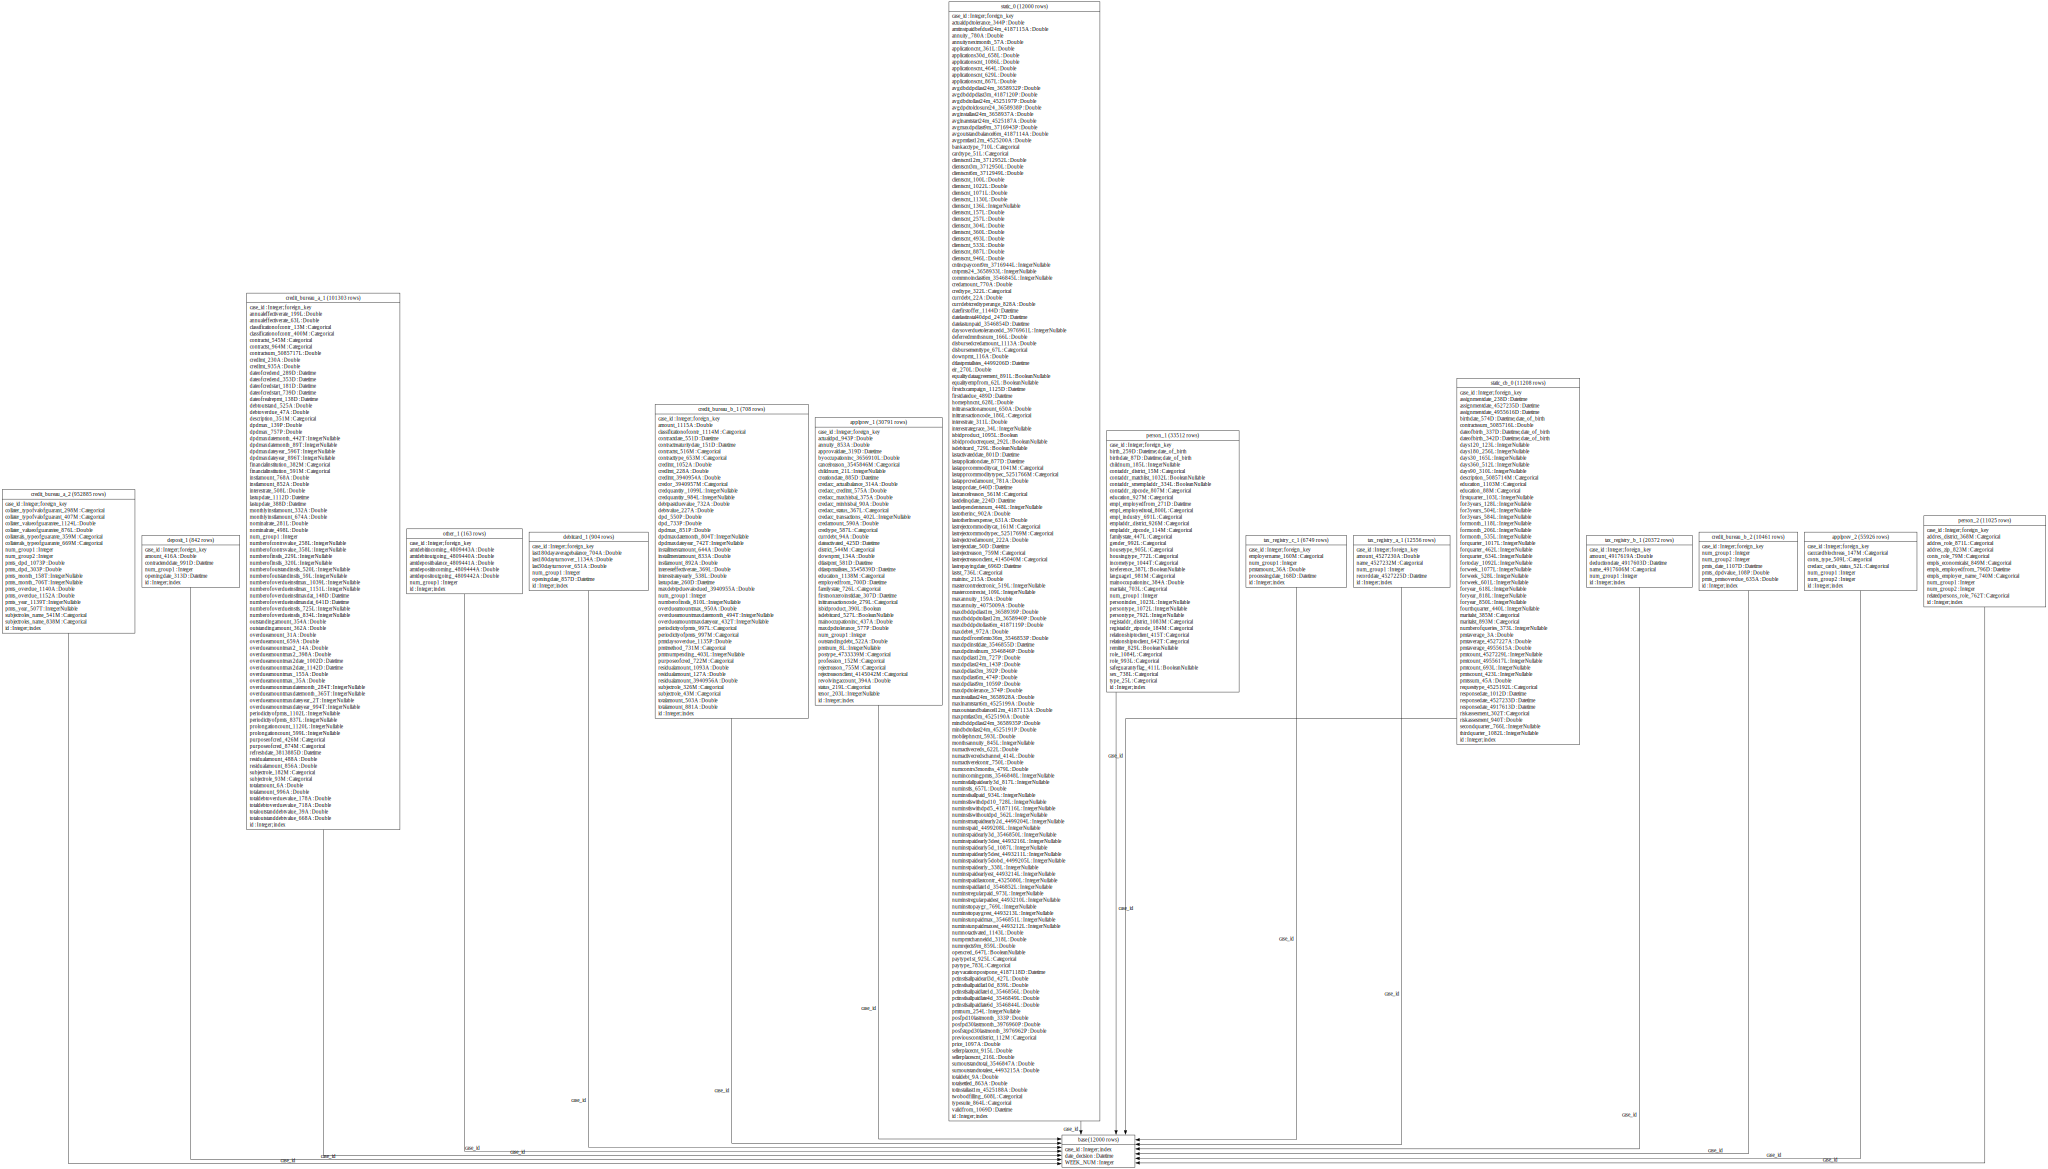

In [10]:
# Visualize the EntitySet and the relationships between the tables
# Should output a pretty large graph
es.plot()

In [11]:
# To get an estimation of the size of one EntitiSet
estimated_size = sys.getsizeof(es)
print(f"Estimated memory usage of EntitySet: {estimated_size/1e9} GB")

Estimated memory usage of EntitySet: 0.223742802 GB


In [12]:
# List the built-in primitives in Featuretools
primitives = ft.list_primitives()
primitives[primitives['type'] == 'aggregation'].head()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,avg_time_between,aggregation,False,False,Computes the average number of seconds between...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
1,max_consecutive_false,aggregation,False,False,Determines the maximum number of consecutive F...,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = Integer) (Semant...
2,count_outside_range,aggregation,False,False,Determines the number of values that fall outs...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
3,n_unique_months,aggregation,False,False,Determines the number of unique months.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
4,std,aggregation,True,True,Computes the dispersion relative to the mean v...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [13]:
primitives[primitives['type'] == 'transform'].head()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,cum_min,transform,False,False,Calculates the cumulative minimum.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
66,exponential_weighted_std,transform,False,False,Computes the exponentially weighted moving sta...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...
67,modulo_numeric,transform,True,True,Performs element-wise modulo of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
68,negate,transform,True,True,Negates a numeric value.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
69,whitespace_count,transform,False,False,Calculates number of whitespaces in a string.,<ColumnSchema (Logical Type = NaturalLanguage)>,<ColumnSchema (Logical Type = IntegerNullable)...


In [14]:
# Selection a set of aggregation and transformation primitives to run DFS
agg_primitives = ["sum", "num_unique", "std", "max", "skew", "min", "mean", "count", "percent_true", "mode", "max_min_delta", "entropy"]
trans_primitives = ["year", "month", "weekday", "season", "is_null", "percentile", "age"]

# DFS with specified primitives
# This will only returns the names of the features without calculating the actual feature matrix
feature_names = ft.dfs(entityset=es, target_dataframe_name='base',
                       trans_primitives=trans_primitives,
                       agg_primitives=agg_primitives, 
                       max_depth=1, n_jobs=-1, verbose=1,
                       features_only=True)

Built 2526 features


In [15]:
# 2526 features were built, let's take a look at some of them
len(feature_names), feature_names[:10]

(2526,
 [<Feature: WEEK_NUM>,
  <Feature: COUNT(tax_registry_c_1)>,
  <Feature: ENTROPY(tax_registry_c_1.employername_160M)>,
  <Feature: MAX(tax_registry_c_1.num_group1)>,
  <Feature: MAX(tax_registry_c_1.pmtamount_36A)>,
  <Feature: MAX_MIN_DELTA(tax_registry_c_1.num_group1)>,
  <Feature: MAX_MIN_DELTA(tax_registry_c_1.pmtamount_36A)>,
  <Feature: MEAN(tax_registry_c_1.num_group1)>,
  <Feature: MEAN(tax_registry_c_1.pmtamount_36A)>,
  <Feature: MIN(tax_registry_c_1.num_group1)>])

In [16]:
# Save the feature names
ft.save_features(feature_names, 'features.txt')

## ***Calculate the feature matrices with Dask***

In the previous step we have just defined the features with DFS but we haven't calculated the actual values of each feature for each case_id in the subset (partition). That's where the problems start, as I said earlier the dataset for this competition is huge. Even with the supermachine offered by kaggle calculating the 2526 featues for one partition should take about 20 minutes, so approximately 42 hours to complete this operation on all the partions (20 * 128) / 60 ~= 42.\
We definitely need a better approach and Dask gives us this second option. By parallelizing the operations needed to calculate the feature matrix for one partition (Creating entityset from partition and calculating feature matrix from ES) Dask will be able to load different EntiySets on all the available cpu cores and calculate their feature matrices independently and simultaneously on those cores.\
If you run this on kaggle you should have 4 cores. The tasks must be small enough that they don't exhaust the memory of an individual worker. Basically the amount of RAM allocated to each cpu core is the total amount of available RAM divided by the number of cores, 8 GB with a kaggle notebook, that is largely enough for the operations needed to create an EntitySet from a partition and calculate the feature matrix for this ES

In [17]:
# Create the directory to store the feature matrices
!mkdir feature_matrices
%ls

feature_matrices/  features.txt  partitions/


In [18]:
!nproc --all # display the number of cores of the machine

4


In [19]:
# Free up memory before
del es_dict, es
gc.collect()

32

In [20]:
# Use all 4 cores
client = Client(processes = True)
client.ncores()

{'tcp://127.0.0.1:33985': 1,
 'tcp://127.0.0.1:35909': 1,
 'tcp://127.0.0.1:36533': 1,
 'tcp://127.0.0.1:46523': 1}

In [21]:
# list paths to all the partitions
paths = glob.glob("partitions/*")

paths[:4], len(paths)

(['partitions/partition115',
  'partitions/partition87',
  'partitions/partition16',
  'partitions/partition127'],
 128)

In [22]:
# Create a bag object (Note that I had to run two bags with different list of paths baecause the session had expired)
bag = db.from_sequence(paths)
# Map entitySet_from_part function
bag = bag.map(entitySet_from_part, dfs_logical_types=logical_types)
# Map feature_matrix_from_es function
bag = bag.map(feature_matrix_from_es, feature_defs = feature_names)
bag

dask.bag<feature_matrix_from_es, npartitions=64>

In [47]:
bag = bag.persist()
progress(bag)
# Starting operations (This will take a while)
bag.compute()


Done feature matrix 22
Saved feature matrix 22
Initialized dataframe $credit_bureau_b_1, no columns dropped
Initialized dataframe $applprev_2, no columns dropped
Initialized dataframe $credit_bureau_a_1, no columns dropped
Initialized dataframe $deposit_1, no columns dropped
Changed logical type of column isbidproduct_390L from Boolean to BooleanNullable
Initialized dataframe $applprev_1, no columns dropped
Added semantic tag $date_of_birth to col birthdate_574D
Added semantic tag $date_of_birth to col dateofbirth_337D
Added semantic tag $date_of_birth to col dateofbirth_342D
Initialized dataframe $static_cb_0, no columns dropped
Added semantic tag $date_of_birth to col birth_259D
Added semantic tag $date_of_birth to col birthdate_87D
Initialized dataframe $person_1, no columns dropped
Initialized dataframe $person_2, no columns dropped
Initialized dataframe $other_1, no columns dropped
Initialized dataframe $credit_bureau_b_2, no columns dropped
Initialized dataframe $tax_registry_b_

[None, None, None, None, None, None, None, None, None, None]

**Note that the first bag ran into a ValueError with some partitions, complaining with one or more columns identified as Booleans in the reference partition used to build the features (partition5) while actually containing null values in those partitions. Function "read_and_init_ww" was modified to tackle this problem for the second run**\
What's great with dask Client API is that (as long as our tasks are independent) an error occuring in one task doesn't impact the others. Indeed Dask continues to execute the other tasks in the background so we don't have to rerun the first bag.

In [4]:
%ls feature_matrices

partition100_fm.parquet  partition23_fm.parquet  partition62_fm.parquet
partition101_fm.parquet  partition24_fm.parquet  partition63_fm.parquet
partition102_fm.parquet  partition25_fm.parquet  partition64_fm.parquet
partition103_fm.parquet  partition26_fm.parquet  partition65_fm.parquet
partition104_fm.parquet  partition27_fm.parquet  partition66_fm.parquet
partition105_fm.parquet  partition28_fm.parquet  partition67_fm.parquet
partition106_fm.parquet  partition29_fm.parquet  partition68_fm.parquet
partition107_fm.parquet  partition2_fm.parquet   partition69_fm.parquet
partition108_fm.parquet  partition30_fm.parquet  partition6_fm.parquet
partition109_fm.parquet  partition31_fm.parquet  partition70_fm.parquet
partition10_fm.parquet   partition32_fm.parquet  partition71_fm.parquet
partition110_fm.parquet  partition33_fm.parquet  partition72_fm.parquet
partition111_fm.parquet  partition34_fm.parquet  partition73_fm.parquet
partition112_fm.parquet  partition35_fm.parquet  partition74_fm.p

In [7]:
len(glob.glob("feature_matrices/*")) # The number of feature matrices created should be equal to the number of partitions = 128

128

In [12]:
# Zip the directory to finally export it to kaggle dataset
!zip -r fms.zip feature_matrices

  adding: feature_matrices/ (stored 0%)
  adding: feature_matrices/partition45_fm.parquet (deflated 33%)
  adding: feature_matrices/partition50_fm.parquet (deflated 32%)
  adding: feature_matrices/partition121_fm.parquet (deflated 20%)
  adding: feature_matrices/partition78_fm.parquet (deflated 20%)
  adding: feature_matrices/partition86_fm.parquet (deflated 21%)
  adding: feature_matrices/partition87_fm.parquet (deflated 21%)
  adding: feature_matrices/partition46_fm.parquet (deflated 33%)
  adding: feature_matrices/partition124_fm.parquet (deflated 21%)
  adding: feature_matrices/partition55_fm.parquet (deflated 27%)
  adding: feature_matrices/partition58_fm.parquet (deflated 25%)
  adding: feature_matrices/partition1_fm.parquet (deflated 40%)
  adding: feature_matrices/partition67_fm.parquet (deflated 21%)
  adding: feature_matrices/partition99_fm.parquet (deflated 21%)
  adding: feature_matrices/partition114_fm.parquet (deflated 27%)
  adding: feature_matrices/partition62_fm.parque

In [14]:
from IPython.display import FileLink
FileLink('fms.zip')

/kaggle/working/fms.zip

## ***Conclusion***

It's my first time to take more time to execute a code than to write it (funny). I hope this notebook and the associated dataset can help the competitors (even though the competition is almost over). I made the feature matrices a [dataset](http://www.kaggle.com/datasets/diarray/deep-feature-synthesis-home-credit-stability) so competitors who want to use it for the competition don't have to lose 20 hours or more running this notebook.

As you saw earlier DFS has generated 2526 features determined by the primitives we gave to the function and the logical types of the columns in the different tables, extracting good features from raw data is a task that requires intuition and experience. Deep Feature Synthesis is based on that intuition so it can generate a lot of features that a Data engineer would think of (and also a lot that we as humans would never think of) but obviously all those are not good features, getting 2000+ meaningful features just by calling a function is more about magic than computer science. This means that the features generated by DFS need to go through a thorough **feature selection** process to select the best features for training. However this task sounds much simpler than feature engineering.

Additionally, even with Dask this code may not be adapted for feature engineering in a submission notebook, we could consider several partitioning and threading options to try to decrease the time needed to calculate feature matrices for the whole dataset but we may still end up with more than a 12 hours runtime on kaggle. If the hidden test set for the competition contains indeed 90% of the numbers of case_id values of the train set, then this code may not be usable for submissions (even if we reduce the number of features to calculate).

**Thanks for reading, and good luck to all the competitors for this final week**

## ***References***
1. Kanter, J. M., & Veeramachaneni, K. (2015). Deep feature synthesis: Towards automating data science endeavors. In 2015 IEEE International Conference on Data Science and Advanced Analytics (DSAA) (pp. 1-10). IEEE.

2. Alteryx. (2018). Predict Loan Repayment: Automated Loan Repayment. GitHub. https://github.com/alteryx/predict-loan-repayment/blob/master/Automated%20Loan%20Repayment.ipynb

3. Alteryx. (2018). Automated-Manual-Comparison: Loan Repayment. GitHub. https://github.com/alteryx/Automated-Manual-Comparison/blob/master/Loan%20Repayment/notebooks/Featuretools%20on%20Dask.ipynb

4. Featuretools/Alteryx. (n.d.). Transition to Featuretools v1.0 — Featuretools 1.30.0 documentation. Retrieved [May 2024], from https://featuretools.alteryx.com/en/v1.30.0/resources/transition_to_ft_v1.0.html

5. Dask Development Team (2016). Dask: Library for dynamic task scheduling
URL http://dask.pydata.org
